In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from config import constants

In [3]:
IS_BINARY = False

In [4]:
if IS_BINARY:
    DATASET_PATH = 'datasets/data/benign_or_attack'
else:
    DATASET_PATH = 'datasets/data/different_features'

In [5]:
CATEGORIES = constants.CATEGORIES
print(CATEGORIES)

['cloud_service', 'e-mail', 'games', 'information', 'music', 'social_network', 'video_hosting']


In [6]:
csv_files = glob(os.path.join(DATASET_PATH, "*.csv"))
print(f"IS_BINARY: { IS_BINARY } \n{ csv_files }")

IS_BINARY: False 
['datasets/data/different_features\\traffic_features.csv']


In [7]:
data_frames = []

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file, delimiter=',')
        print(f"Файл {csv_file}: {df.shape[0]} строк, {df.shape[1]} столбцов")
        data_frames.append(df)
    except Exception as e:
        print(f"Ошибка при чтении {csv_file}: {e}")

if not data_frames:
    raise ValueError("Не удалось прочитать ни один CSV-файл.")

Файл datasets/data/different_features\traffic_features.csv: 565 строк, 78 столбцов


In [8]:
data = pd.concat(data_frames, ignore_index=True)
print(f"Объединённый DataFrame из {len(csv_files)} файла: {data.shape[0]} строк, {data.shape[1]} столбцов")

Объединённый DataFrame из 1 файла: 565 строк, 78 столбцов


In [9]:
data = data.dropna()
data = data.fillna(0).replace([np.inf, -np.inf], 0)
data.columns = data.columns.str.strip()

In [10]:
print(data.shape)

(565, 78)


In [11]:
data['Label'].unique()

array(['games', 'cloud_service', 'video_hosting', 'social_network',
       'e-mail', 'music', 'information'], dtype=object)

In [12]:
X = data.drop('Label', axis=1)
if IS_BINARY:
    y = np.where(data['Label'] == 'BENIGN', 0, 1)
else:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Label'])

In [13]:
feature_names = X.columns
print(feature_names)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [16]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [17]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_d=32, n_a=32, n_steps=3, gamma=1.3,
                 n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.momentum = momentum

        self.initial_bn = nn.BatchNorm1d(input_dim, momentum=momentum)
        self.initial_splitter = FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
        self.attentive_transformers = nn.ModuleList([
            AttentiveTransformer(input_dim, n_a, momentum) for _ in range(n_steps)  # Используем n_a вместо n_d + n_a
        ])
        self.feature_transformers = nn.ModuleList([
            FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
            for _ in range(n_steps)
        ])
        self.final_linear = nn.Linear(n_d, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.initial_bn(x)
        prior = torch.ones(batch_size, self.input_dim, device=x.device)
        M_loss = 0
        outputs = []
        M = []

        features = self.initial_splitter(x)
        d, a = features[:, :self.n_d], features[:, self.n_d:]

        for step in range(self.n_steps):
            M_i = self.attentive_transformers[step](a, prior)
            M.append(M_i)
            M_loss += torch.mean(torch.sum(-M_i * torch.log(M_i + self.epsilon), dim=1))
            prior = self.gamma - M_i
            prior = torch.cumprod(prior, dim=0)
            masked_x = M_i * x
            features = self.feature_transformers[step](masked_x)
            d, a = features[:, :self.n_d], features[:, self.n_d:]
            outputs.append(d)

        out = torch.stack(outputs, dim=1).sum(dim=1)
        out = self.final_linear(out)
        return out, M, M_loss / self.n_steps

In [20]:
class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_independent, n_shared, momentum):
        super(FeatureTransformer, self).__init__()
        self.shared = nn.ModuleList()
        for i in range(n_shared):
            in_features = input_dim if i == 0 else output_dim
            self.shared.append(nn.Sequential(
                nn.Linear(in_features, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU()
            ))
        self.independent = nn.ModuleList()
        for _ in range(n_independent):
            self.independent.append(nn.Sequential(
                nn.Linear(output_dim, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU()
            ))

    def forward(self, x):
        shared_out = x
        for layer in self.shared:
            shared_out = layer(shared_out)
        out = shared_out
        for layer in self.independent:
            out = layer(out)
        return out

In [21]:
class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, n_a, momentum):  # Изменено: используем n_a вместо output_dim
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(n_a, input_dim)  # Вход: n_a, выход: input_dim
        self.bn = nn.BatchNorm1d(input_dim, momentum=momentum)

    def forward(self, a, prior):
        a = self.fc(a)
        a = self.bn(a)
        a = a * prior
        return sparsemax(a)

In [22]:
def sparsemax(x):
    """Sparsemax function for attention mechanism"""
    sorted_x, _ = torch.sort(x, dim=1, descending=True)
    cumsum = torch.cumsum(F.softmax(sorted_x, dim=1), dim=1)
    rho = (cumsum <= 1).sum(dim=1, keepdim=True)
    tau = (cumsum.gather(1, rho - 1) - 1) / rho
    out = F.relu(x - tau)
    return out / (out.sum(dim=1, keepdim=True) + 1e-15)

In [23]:
def train_tabnet(model, train_loader, test_loader, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output, M, M_loss = model(data)
            loss = F.cross_entropy(output, target) + 0.01 * M_loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Оценка на тестовом наборе
        model.eval()
        total_test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output, _, M_loss = model(data)
                test_loss = F.cross_entropy(output, target) + 0.01 * M_loss
                total_test_loss += test_loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        train_loss = total_train_loss / len(train_loader)
        test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100. * correct / total
        print(f'Эпоха {epoch+1}, Тренировочные потери: {train_loss:.4f}, '
              f'Тестовые потери: {test_loss:.4f}, Тестовая точность: {test_accuracy:.2f}%')

In [24]:
def get_feature_importance(model, data_loader, device, feature_names):
    model.eval()
    feature_importance = torch.zeros(model.input_dim).to(device)
    total_samples = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            _, masks, _ = model(data)
            for mask in masks:
                feature_importance += mask.sum(dim=0)
            total_samples += data.size(0)
    importance = feature_importance.cpu().numpy() / total_samples

    return pd.Series(importance, index=feature_names)

In [27]:
# Инициализация модели
input_dim = X.shape[1]
output_dim = len(np.unique(y))
model = TabNet(input_dim=input_dim, output_dim=output_dim, n_d=32, n_a=32).to(device)

# Настройка оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
epochs = 40
train_tabnet(model, train_loader, test_loader, optimizer, epochs, device)

Эпоха 1, Тренировочные потери: 1.6251, Тестовые потери: 1.8739, Тестовая точность: 21.05%
Эпоха 2, Тренировочные потери: 1.7902, Тестовые потери: 1.6252, Тестовая точность: 54.39%
Эпоха 3, Тренировочные потери: 1.4741, Тестовые потери: 1.3141, Тестовая точность: 50.88%
Эпоха 4, Тренировочные потери: 1.3989, Тестовые потери: 1.3261, Тестовая точность: 43.86%
Эпоха 5, Тренировочные потери: 1.3822, Тестовые потери: 1.3273, Тестовая точность: 47.37%
Эпоха 6, Тренировочные потери: 1.3151, Тестовые потери: 1.2987, Тестовая точность: 45.61%
Эпоха 7, Тренировочные потери: 1.2534, Тестовые потери: 1.2530, Тестовая точность: 49.12%
Эпоха 8, Тренировочные потери: 1.2167, Тестовые потери: 1.3363, Тестовая точность: 45.61%
Эпоха 9, Тренировочные потери: 1.2411, Тестовые потери: 1.2062, Тестовая точность: 49.12%
Эпоха 10, Тренировочные потери: 1.2944, Тестовые потери: 1.2450, Тестовая точность: 52.63%
Эпоха 11, Тренировочные потери: 1.2245, Тестовые потери: 1.0821, Тестовая точность: 59.65%
Эпоха 12


Важность признаков (топ-10):
Destination Port          0.630562
Packet Length Std         0.456140
Fwd Packet Length Mean    0.400430
Flow Duration             0.343232
Fwd Header Length         0.229662
Fwd Packets/s             0.200600
Fwd IAT Mean              0.152049
Idle Max                  0.132629
FIN Flag Count            0.104852
Idle Min                  0.082537
dtype: float32


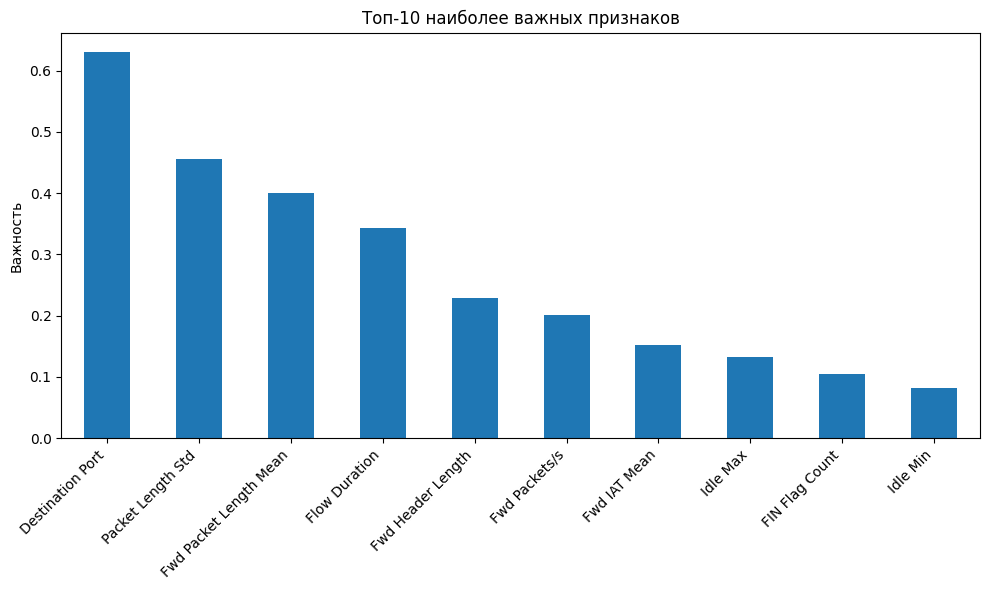

In [26]:
# Анализ важности признаков
importance = get_feature_importance(model, test_loader, device, feature_names)
print("\nВажность признаков (топ-10):")
print(importance.sort_values(ascending=False).head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
importance.sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Топ-10 наиболее важных признаков')
plt.ylabel('Важность')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()